# Explainable Machine Learning for Academic Risk Prediction

**Course:** IT41033 — Nature Inspired Algorithms (Mini Project)

**Project Workflow:**

  *1. Data Understanding*

  *2. Data Preprocessing*

  *3. Data Mining & Machine Learning*

  *4. Evaluation & Interpretation*

  *5. Deployment*


### 1) Setup & Installs

In [1]:
# Install packages
%pip -q install shap lime scikit-learn pandas numpy matplotlib seaborn joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### 2) Imports & Global Config

In [2]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, joblib, json, os, itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import shap
from lime.lime_tabular import LimeTabularExplainer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (8, 5)


### 3) Data Loading

In [3]:
DATA_PATH = '/content/Student_performance_data _.csv'

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
print("Shape:", df.shape)
df.head()

Shape: (2392, 15)


StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196         2.0  
1             0  3.042915         1.0  
2             0  0.112602         4.0  
3             0  2.054218         3.0  
4             0  1.288061         4.0

### 4) Define Problem & Target

In [4]:
# Expect a categorical target 'GradeClass' (A, B, C, D, F).
TARGET_CANDIDATES = ["GradeClass", "grade_class", "gradeclass", "target"]
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c; break
assert target_col is not None, f"Target column not found. Candidates tried: {TARGET_CANDIDATES}\nColumns: {df.columns.tolist()}"

y = df[target_col].astype(str)  # ensure string classes
X = df.drop(columns=[target_col])

# Drop obvious ID columns if present
ID_LIKE = [c for c in X.columns if "id" in c.lower() or "student" in c.lower() and "id" in c.lower()]
if ID_LIKE:
    X = X.drop(columns=ID_LIKE)

print("Target distribution:")
print(y.value_counts(normalize=True).round(3))
print("\nFeatures:", X.shape[1])


Target distribution:
GradeClass
4.0    0.506
3.0    0.173
2.0    0.163
1.0    0.112
0.0    0.045
Name: proportion, dtype: float64

Features: 13


### 5) Data Understanding & Exploration (EDA)

In [5]:
display(df.info())
display(df.describe(include='all').T.iloc[:30])

# Missing values
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:")
display(missing[missing>0])

# Duplicates
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


None

count         mean         std          min          25%  \
StudentID          2392.0  2196.500000  690.655244  1001.000000  1598.750000   
Age                2392.0    16.468645    1.123798    15.000000    15.000000   
Gender             2392.0     0.510870    0.499986     0.000000     0.000000   
Ethnicity          2392.0     0.877508    1.028476     0.000000     0.000000   
ParentalEducation  2392.0     1.746237    1.000411     0.000000     1.000000   
StudyTimeWeekly    2392.0     9.771992    5.652774     0.001057     5.043079   
Absences           2392.0    14.541388    8.467417     0.000000     7.000000   
Tutoring           2392.0     0.301421    0.458971     0.000000     0.000000   
ParentalSupport    2392.0     2.122074    1.122813     0.000000     1.000000   
Extracurricular    2392.0     0.383361    0.486307     0.000000     0.000000   
Sports             2392.0     0.303512    0.459870     0.000000     0.000000   
Music              2392.0     0.196906    0.397744     0.000000     0.000000   
Volunteering       2392.0     0.157191    0.364057     0.000000     0.000000   
GPA                2392.0     1.906186    0.915156     0.000000     1.174803   
GradeClass         2392.0     2.983696    1.233908     0.000000     2.000000   

                           50%          75%          max  
StudentID          2196.500000  2794.250000  3392.000000  
Age                  16.000000    17.000000    18.000000  
Gender                1.000000     1.000000     1.000000  
Ethnicity             0.000000     2.000000     3.000000  
ParentalEducation     2.000000     2.000000     4.000000  
StudyTimeWeekly       9.705363    14.408410    19.978094  
Absences             15.000000    22.000000    29.000000  
Tutoring              0.000000     1.000000     1.000000  
ParentalSupport       2.000000     3.000000     4.000000  
Extracurricular       0.000000     1.000000     1.000000  
Sports                0.000000     1.000000     1.000000  
Music                 0.000000     0.000000     1.000000  
Volunteering          0.000000     0.000000     1.000000  
GPA                   1.893393     2.622216     4.000000  
GradeClass            4.000000     4.000000     4.000000

Missing values per column:


Series([], dtype: int64)

Duplicate rows: 0


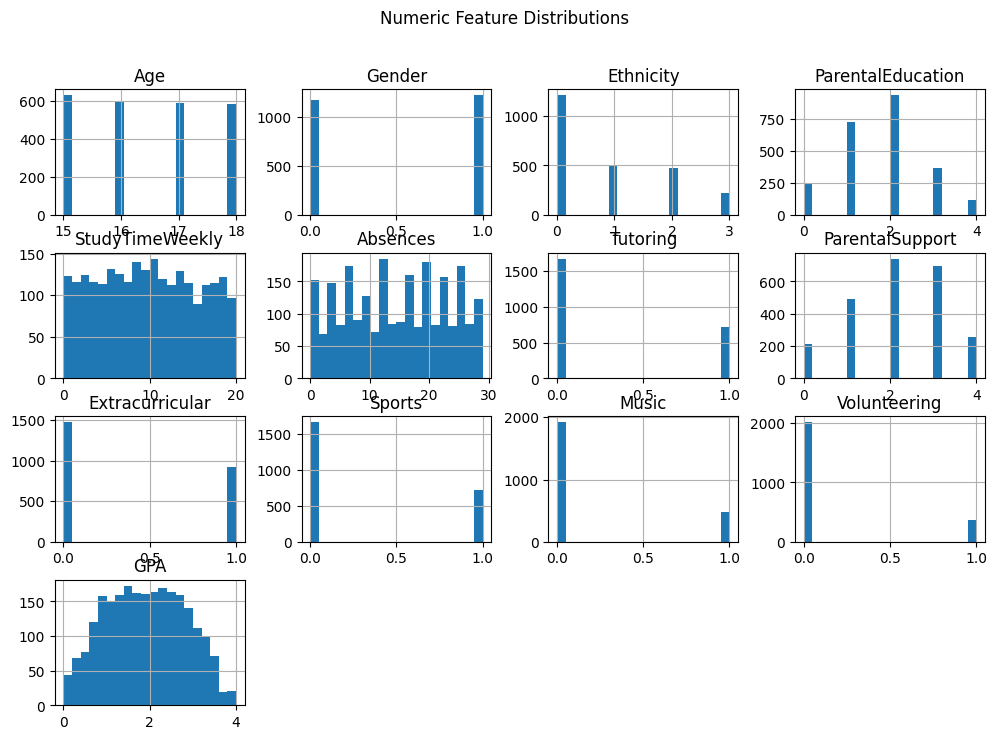

In [6]:
# Basic visualizations
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

if numeric_cols:
    df[numeric_cols].hist(bins=20, figsize=(12,8))
    plt.suptitle("Numeric Feature Distributions")
    plt.show()

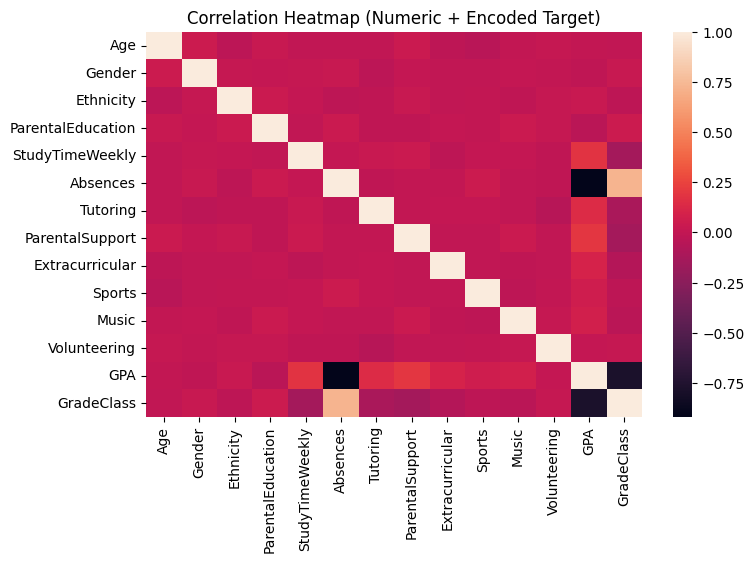

In [7]:
if numeric_cols:
    corr = df[numeric_cols + [target_col]].copy()
    # Encode target temporarily to compute correlation with numeric features
    corr[target_col] = pd.Categorical(df[target_col]).codes
    corr_mat = corr.corr()
    sns.heatmap(corr_mat, annot=False)
    plt.title("Correlation Heatmap (Numeric + Encoded Target)")
    plt.show()

<Figure size 800x500 with 0 Axes>

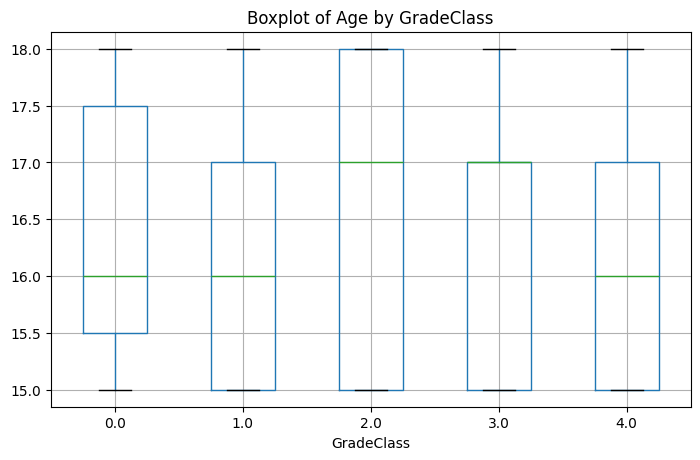

<Figure size 800x500 with 0 Axes>

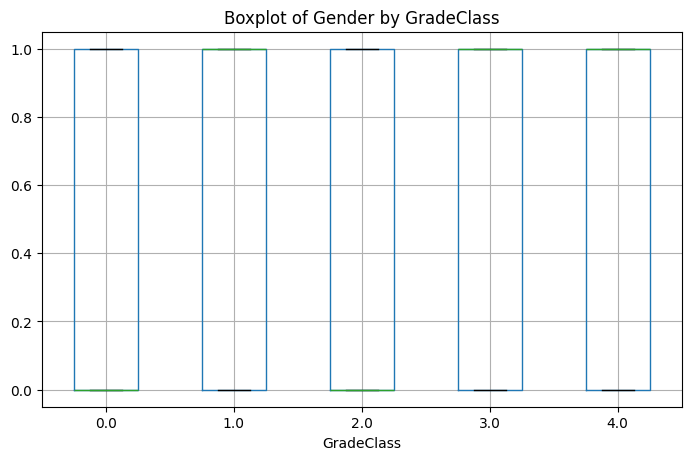

<Figure size 800x500 with 0 Axes>

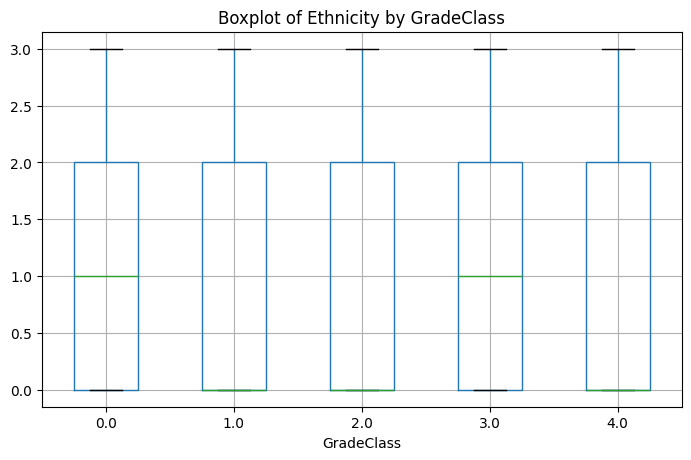

<Figure size 800x500 with 0 Axes>

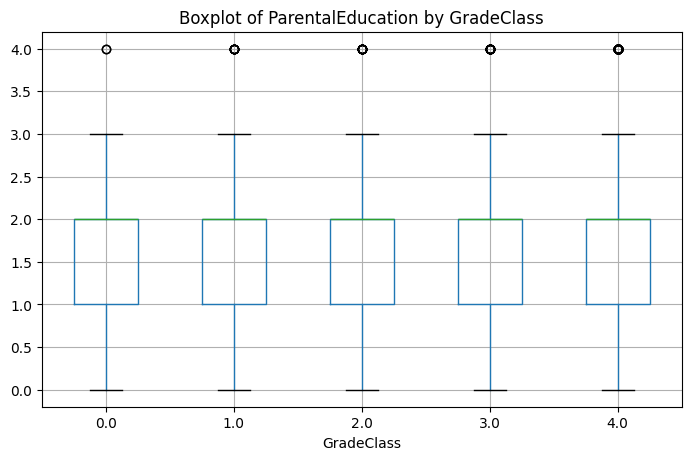

<Figure size 800x500 with 0 Axes>

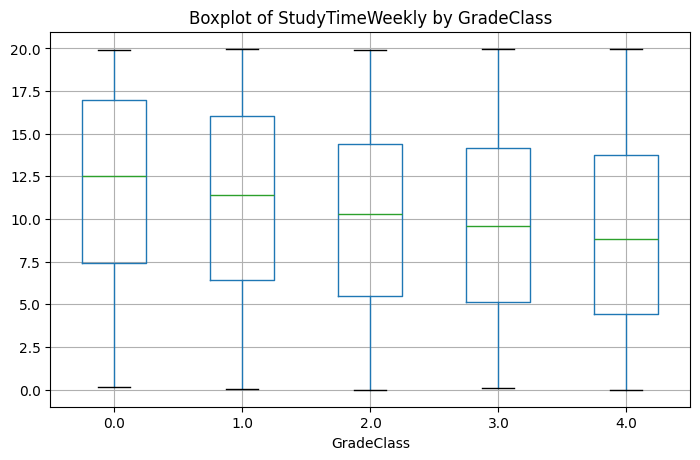

<Figure size 800x500 with 0 Axes>

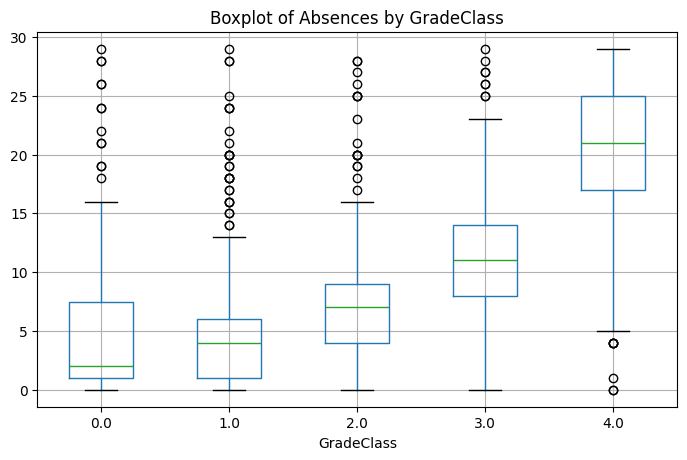

In [8]:
# boxplots for outliers (first few numeric columns)
for col in numeric_cols[:6]:
    plt.figure()
    df.boxplot(column=col, by=target_col)
    plt.title(f"Boxplot of {col} by {target_col}")
    plt.suptitle("")
    plt.show()

### 6) Data Preprocessing

In [9]:
# Robust Column detection
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


Numeric: ['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA']
Categorical: []


### 7) Baseline Models

In [10]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=RANDOM_STATE)
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

results = []

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # Some metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    results.append([name, acc, prec, rec, f1, pipe])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)","Pipeline"])
results_df.sort_values("F1(macro)", ascending=False, inplace=True)
display(results_df[["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)"]].reset_index(drop=True))
best_name = results_df.iloc[0]["Model"]
best_pipe = results_df.iloc[0]["Pipeline"]
print(f"Best baseline: {best_name}")


Model  Accuracy  Precision(macro)  Recall(macro)  F1(macro)
0    GradientBoosting  0.918580          0.908892       0.831924   0.856778
1        RandomForest  0.910230          0.908960       0.789809   0.809419
2                 SVC  0.795407          0.738211       0.637434   0.649732
3  LogisticRegression  0.801670          0.674233       0.626272   0.638937
4                 MLP  0.776618          0.622431       0.619749   0.618710

Best baseline: GradientBoosting


### 8) Hyperparameter Tuning (Top Candidates)

In [11]:
# Pick top-2 baselines for tuning
top2 = results_df.head(2)["Model"].tolist()

param_spaces = {
    "RandomForest": {
        "model__n_estimators": [100, 200, 300, 500],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },
    "SVC": {
        "model__C": [0.1, 1, 10, 100],
        "model__gamma": ["scale", "auto"],
        "model__kernel": ["rbf", "poly", "sigmoid"]
    },
    "GradientBoosting": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [2, 3, 4]
    },
    "MLP": {
        "model__hidden_layer_sizes": [(128,64), (256,128), (128,64,32)],
        "model__alpha": [1e-5, 1e-4, 1e-3],
        "model__learning_rate_init": [0.001, 0.01],
        "model__max_iter": [300, 500]
    },
    "LogisticRegression": {
        "model__C": [0.1, 1, 10],
        "model__solver": ["lbfgs", "saga"]
    }
}

tuned_records = []
for name in top2:
    clf = models[name]
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', clf)])
    params = param_spaces.get(name, {})
    if params:
        tuner = RandomizedSearchCV(
            pipe, params, n_iter=10, scoring='f1_macro',
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
            random_state=RANDOM_STATE, n_jobs=-1, verbose=1
        )
        tuner.fit(X_train, y_train)
        best_pipe_tuned = tuner.best_estimator_
        y_pred = best_pipe_tuned.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        tuned_records.append([f"{name} (tuned)", acc, prec, rec, f1, best_pipe_tuned])
        print(f"Best params for {name}:", tuner.best_params_)
    else:
        print(f"No param space defined for {name}; skipping.")

tuned_df = pd.DataFrame(tuned_records, columns=["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)","Pipeline"])
if not tuned_df.empty:
    display(tuned_df[["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)"]].reset_index(drop=True))
    # Compare with baselines
    combined = pd.concat([results_df.drop(columns=["Pipeline"]), tuned_df.drop(columns=["Pipeline"])], ignore_index=True)
    display(combined.sort_values("F1(macro)", ascending=False).reset_index(drop=True))
else:
    combined = results_df.drop(columns=["Pipeline"])

# Choose the final best pipeline
if not tuned_df.empty and tuned_df["F1(macro)"].max() >= results_df["F1(macro)"].max():
    final_row = tuned_df.loc[tuned_df["F1(macro)"].idxmax()]
else:
    final_row = results_df.iloc[0]

final_model_name = final_row["Model"]
final_pipe = final_row["Pipeline"]
print("Final selected model:", final_model_name)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for GradientBoosting: {'model__n_estimators': 100, 'model__max_depth': 2, 'model__learning_rate': 0.01}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for RandomForest: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': 20}


Model  Accuracy  Precision(macro)  Recall(macro)  \
0  GradientBoosting (tuned)  0.924843          0.930209       0.844835   
1      RandomForest (tuned)  0.912317          0.911761       0.793512   

   F1(macro)  
0   0.872509  
1   0.812665

Model  Accuracy  Precision(macro)  Recall(macro)  \
0  GradientBoosting (tuned)  0.924843          0.930209       0.844835   
1          GradientBoosting  0.918580          0.908892       0.831924   
2      RandomForest (tuned)  0.912317          0.911761       0.793512   
3              RandomForest  0.910230          0.908960       0.789809   
4                       SVC  0.795407          0.738211       0.637434   
5        LogisticRegression  0.801670          0.674233       0.626272   
6                       MLP  0.776618          0.622431       0.619749   

   F1(macro)  
0   0.872509  
1   0.856778  
2   0.812665  
3   0.809419  
4   0.649732  
5   0.638937  
6   0.618710

Final selected model: GradientBoosting (tuned)


### 9) Final Evaluation & Confusion Matrix

Classification Report (Final Model)
              precision    recall  f1-score   support

         0.0       1.00      0.52      0.69        21
         1.0       0.91      0.89      0.90        54
         2.0       0.91      0.95      0.93        78
         3.0       0.89      0.89      0.89        83
         4.0       0.94      0.97      0.96       243

    accuracy                           0.92       479
   macro avg       0.93      0.84      0.87       479
weighted avg       0.93      0.92      0.92       479



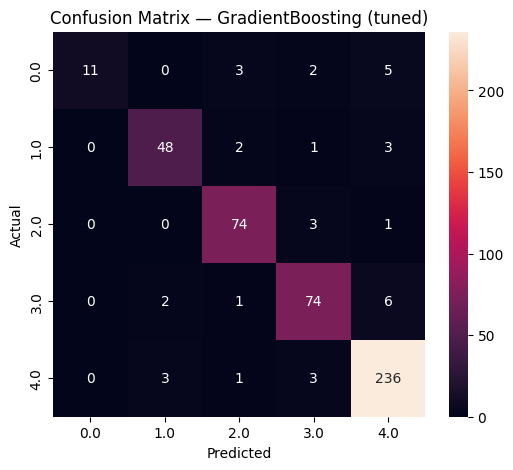

In [12]:
y_pred = final_pipe.predict(X_test)

print("Classification Report (Final Model)")
print(classification_report(y_test, y_pred, zero_division=0))

labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_title(f"Confusion Matrix — {final_model_name}")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
plt.show()


### 10) Explainability — SHAP & LIME

In [13]:
# Prepare transformed data for explainers
final_clf = final_pipe.named_steps['model']

# Fit a pure preprocessing transformer to training data for consistent transforms
preprocess_only = final_pipe.named_steps['preprocess']
X_train_trans = preprocess_only.fit_transform(X_train, y_train)
X_test_trans = preprocess_only.transform(X_test)

# SHAP
try:
    # TreeExplainer if tree-based, otherwise KernelExplainer as fallback
    if isinstance(final_clf, (RandomForestClassifier, GradientBoostingClassifier)):
        explainer = shap.TreeExplainer(final_clf)
        # Small subset for speed
        shap_values = explainer.shap_values(X_test_trans[:200])
        shap.summary_plot(shap_values, X_test_trans[:200], show=False)
        plt.title("SHAP Summary (TreeExplainer)")
        plt.show()
    else:
        # KernelExplainer can be slow; use a small background sample
        background = X_train_trans[np.random.choice(X_train_trans.shape[0], size=min(200, X_train_trans.shape[0]), replace=False)]
        explainer = shap.KernelExplainer(final_clf.predict_proba, background)
        shap_values = explainer.shap_values(X_test_trans[:50])
        shap.summary_plot(shap_values, X_test_trans[:50], show=False)
        plt.title("SHAP Summary (KernelExplainer)")
        plt.show()
except Exception as e:
    print("SHAP failed or not supported in this environment:", e)

# LIME (on the original features)
try:
    # For LIME, we need encoded class names
    class_names = sorted(y.unique().tolist())
    # Identify categorical features indexes for LIME
    cat_idx = [i for i, c in enumerate(X.columns) if c in categorical_cols]
    explainer = LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X.columns.tolist(),
        class_names=class_names,
        categorical_features=cat_idx,
        discretize_continuous=True
    )
    # Explain one random test instance
    i = np.random.randint(0, X_test.shape[0])
    def predict_fn(data):
        return final_pipe.predict_proba(pd.DataFrame(data, columns=X.columns))

    exp = explainer.explain_instance(X_test.iloc[i].values, predict_fn, num_features=10, top_labels=1)
    exp.show_in_notebook(show_table=True)
except Exception as e:
    print("LIME failed or not supported here:", e)


SHAP failed or not supported in this environment: GradientBoostingClassifier is only supported for binary classification right now!


### 11) Fairness / Bias Checks (Subgroup Performance)

In [14]:
# Detect common protected-attribute columns
candidates = [c for c in df.columns if c.lower() in ["gender","sex","ethnicity","race"]]
if candidates:
    attr = candidates[0]
    print(f"Fairness check by subgroup: {attr}")
    subgroup_scores = []
    for val in df[attr].dropna().unique():
        mask = X_test[attr] == val if attr in X_test.columns else pd.Series([False]*len(X_test))
        if mask.sum() < 5:
            continue
        y_true_g = y_test[mask]
        y_pred_g = final_pipe.predict(X_test[mask])
        subgroup_scores.append({
            attr: val,
            "n": mask.sum(),
            "Accuracy": accuracy_score(y_true_g, y_pred_g),
            "Precision(macro)": precision_score(y_true_g, y_pred_g, average='macro', zero_division=0),
            "Recall(macro)": recall_score(y_true_g, y_pred_g, average='macro', zero_division=0),
            "F1(macro)": f1_score(y_true_g, y_pred_g, average='macro', zero_division=0)
        })
    if subgroup_scores:
        fairness_df = pd.DataFrame(subgroup_scores).sort_values("F1(macro)", ascending=False)
        display(fairness_df)
    else:
        print("Not enough subgroup samples to compute fairness metrics.")
else:
    print("No common protected-attribute columns (gender/ethnicity/race) found; skipping fairness check.")


Fairness check by subgroup: Gender


Gender    n  Accuracy  Precision(macro)  Recall(macro)  F1(macro)
0       1  246  0.947154          0.954981       0.913438   0.932220
1       0  233  0.901288          0.909486       0.806111   0.826668

### 12) Save Artifacts (Deployment-Ready Pipeline)

In [15]:
os.makedirs("artifacts", exist_ok=True)

# Save final pipeline and label set
joblib.dump(final_pipe, "artifacts/final_pipeline.joblib")
with open("artifacts/label_classes.json","w") as f:
    json.dump(sorted(y.unique().tolist()), f, indent=2)

# Export comparison table
export_df = pd.DataFrame(columns=["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)"])
export_df = pd.concat([export_df, results_df.drop(columns=["Pipeline"])], ignore_index=True)
if 'combined' in locals():
    export_df = pd.concat([export_df, combined], ignore_index=True)
export_df.drop_duplicates(subset=["Model"], keep='last', inplace=True)
export_df.to_csv("artifacts/model_comparison.csv", index=False)

print("✅ Saved: artifacts/final_pipeline.joblib, artifacts/label_classes.json, artifacts/model_comparison.csv")


✅ Saved: artifacts/final_pipeline.joblib, artifacts/label_classes.json, artifacts/model_comparison.csv


**Notes**

> RANDOM_STATE = 42 is used across the notebook for reproducible splits and tuning.





### Modify data loading and splitting

Remove the 'GPA' column from the feature set and then split the data into training and testing sets.

In [16]:
# Drop the 'GPA' column from the feature set X
if 'GPA' in X.columns:
    X = X.drop(columns=['GPA'])
    print("Dropped 'GPA' column from feature set X.")
else:
    print("'GPA' column not found in feature set X. Skipping drop.")

# Split the updated X DataFrame and the target y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Print the shapes of the new splits to verify
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Dropped 'GPA' column from feature set X.
Shape of X_train: (1913, 12)
Shape of X_test: (479, 12)
Shape of y_train: (1913,)
Shape of y_test: (479,)


### Re-run baseline models

Re-running the cell with the updated X_train and y_train will train and evaluate the baseline models without the 'GPA' feature and display their performance metrics.


But Before, the numeric_cols and categorical_cols lists were defined before dropping the 'GPA' column. So, we need to redefine these lists based on the updated X DataFrame before creating the ColumnTransformer.

In [17]:
# Redefine numeric and categorical columns based on the updated X
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Updated Numeric:", numeric_cols)
print("Updated Categorical:", categorical_cols)

# Redefine the ColumnTransformer with the updated column lists
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Re-run the model training and evaluation
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=RANDOM_STATE)
}

results = []

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # Some metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    results.append([name, acc, prec, rec, f1, pipe])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)","Pipeline"])
results_df.sort_values("F1(macro)", ascending=False, inplace=True)
display(results_df[["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)"]].reset_index(drop=True))
best_name = results_df.iloc[0]["Model"]
best_pipe = results_df.iloc[0]["Pipeline"]
print(f"Best baseline: {best_name}")

Updated Numeric: ['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
Updated Categorical: []


Model  Accuracy  Precision(macro)  Recall(macro)  F1(macro)
0        RandomForest  0.716075          0.583066       0.542212   0.550786
1  LogisticRegression  0.726514          0.574060       0.532930   0.540117
2    GradientBoosting  0.684760          0.561057       0.526614   0.534095
3                 SVC  0.697286          0.620558       0.511659   0.518151
4                 MLP  0.657620          0.500031       0.507102   0.501971

Best baseline: RandomForest


### Re-run hyperparameter tuning

Re-run the hyperparameter tuning cell to find the best model configurations for the top 2 baseline models using the data without the 'GPA' feature.

In [18]:
# Pick top-2 baselines for tuning based on the updated results
top2 = results_df.head(2)["Model"].tolist()

# Use the previously defined param_spaces dictionary

tuned_records = []
for name in top2:
    clf = models[name]
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', clf)])
    params = param_spaces.get(name, {})
    if params:
        tuner = RandomizedSearchCV(
            pipe, params, n_iter=10, scoring='f1_macro',
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
            random_state=RANDOM_STATE, n_jobs=-1, verbose=1
        )
        tuner.fit(X_train, y_train)
        best_pipe_tuned = tuner.best_estimator_
        y_pred = best_pipe_tuned.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        tuned_records.append([f"{name} (tuned)", acc, prec, rec, f1, best_pipe_tuned])
        print(f"Best params for {name}:", tuner.best_params_)
    else:
        print(f"No param space defined for {name}; skipping.")

tuned_df = pd.DataFrame(tuned_records, columns=["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)","Pipeline"])
if not tuned_df.empty:
    display(tuned_df[["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)"]].reset_index(drop=True))
    # Compare with baselines
    combined = pd.concat([results_df.drop(columns=["Pipeline"]), tuned_df.drop(columns=["Pipeline"])], ignore_index=True)
    display(combined.sort_values("F1(macro)", ascending=False).reset_index(drop=True))
else:
    combined = results_df.drop(columns=["Pipeline"])

# Choose the final best pipeline
if not tuned_df.empty and tuned_df["F1(macro)"].max() >= results_df["F1(macro)"].max():
    final_row = tuned_df.loc[tuned_df["F1(macro)"].idxmax()]
else:
    final_row = results_df.iloc[0]

final_model_name = final_row["Model"]
final_pipe = final_row["Pipeline"]
print("Final selected model:", final_model_name)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for RandomForest: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': None}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for LogisticRegression: {'model__solver': 'lbfgs', 'model__C': 10}


Model  Accuracy  Precision(macro)  Recall(macro)  \
0        RandomForest (tuned)  0.722338          0.636488       0.544042   
1  LogisticRegression (tuned)  0.728601          0.586769       0.542454   

   F1(macro)  
0   0.545421  
1   0.552009

Model  Accuracy  Precision(macro)  Recall(macro)  \
0  LogisticRegression (tuned)  0.728601          0.586769       0.542454   
1                RandomForest  0.716075          0.583066       0.542212   
2        RandomForest (tuned)  0.722338          0.636488       0.544042   
3          LogisticRegression  0.726514          0.574060       0.532930   
4            GradientBoosting  0.684760          0.561057       0.526614   
5                         SVC  0.697286          0.620558       0.511659   
6                         MLP  0.657620          0.500031       0.507102   

   F1(macro)  
0   0.552009  
1   0.550786  
2   0.545421  
3   0.540117  
4   0.534095  
5   0.518151  
6   0.501971

Final selected model: LogisticRegression (tuned)


### Re-run final evaluation

Execute the code cell to perform the final evaluation and generate the confusion matrix for the selected final model, assessing its performance without the GPA feature.

Classification Report (Final Model)
              precision    recall  f1-score   support

         0.0       0.40      0.19      0.26        21
         1.0       0.53      0.43      0.47        54
         2.0       0.51      0.68      0.58        78
         3.0       0.59      0.47      0.52        83
         4.0       0.90      0.95      0.92       243

    accuracy                           0.73       479
   macro avg       0.59      0.54      0.55       479
weighted avg       0.72      0.73      0.72       479



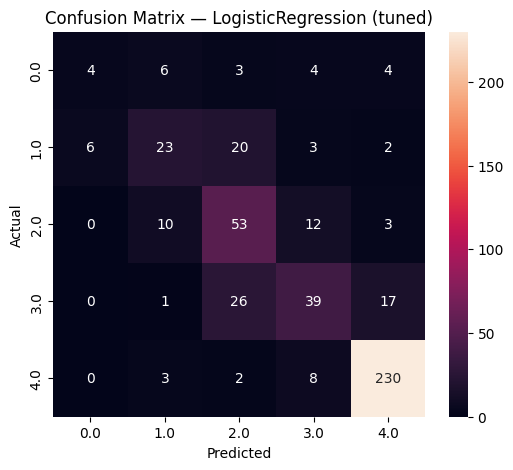

In [19]:
y_pred = final_pipe.predict(X_test)

print("Classification Report (Final Model)")
print(classification_report(y_test, y_pred, zero_division=0))

labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_title(f"Confusion Matrix — {final_model_name}")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
plt.show()

### Re-run explainability

Re-run the existing explainability code to generate SHAP and LIME plots for the final model trained without the GPA feature.

  0%|          | 0/50 [00:00<?, ?it/s]

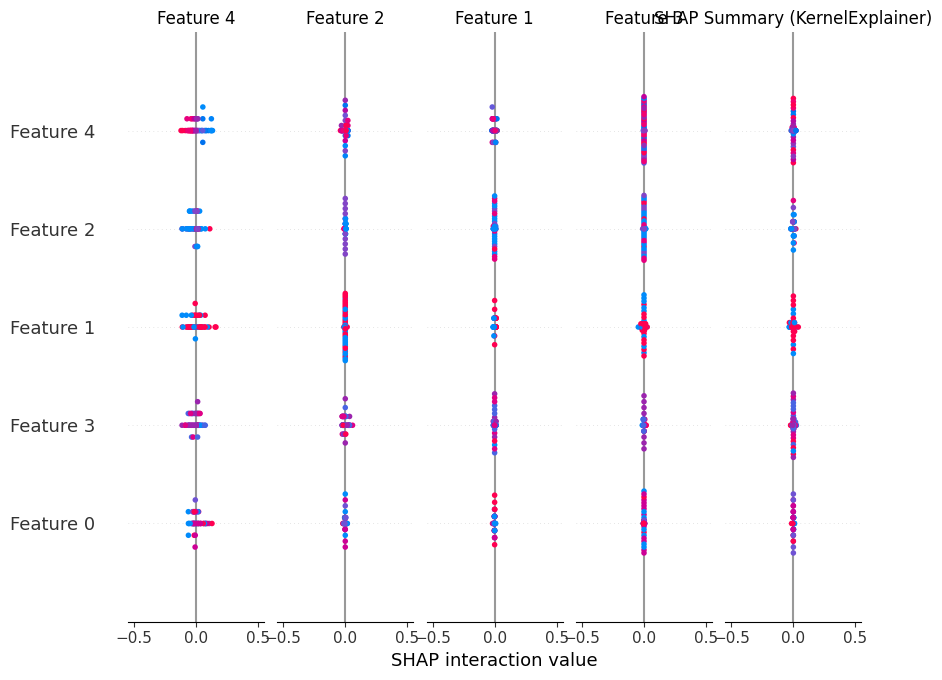

In [20]:
# Prepare transformed data for explainers
final_clf = final_pipe.named_steps['model']
# Fit a pure preprocessing transformer to training data for consistent transforms
preprocess_only = final_pipe.named_steps['preprocess']
X_train_trans = preprocess_only.fit_transform(X_train, y_train)
X_test_trans = preprocess_only.transform(X_test)

# SHAP
try:
    # TreeExplainer if tree-based, otherwise KernelExplainer as fallback
    if isinstance(final_clf, (RandomForestClassifier, GradientBoostingClassifier)):
        explainer = shap.TreeExplainer(final_clf)
        # Small subset for speed
        shap_values = explainer.shap_values(X_test_trans[:200])
        shap.summary_plot(shap_values, X_test_trans[:200], show=False)
        plt.title("SHAP Summary (TreeExplainer)")
        plt.show()
    else:
        # KernelExplainer can be slow; use a small background sample
        background = X_train_trans[np.random.choice(X_train_trans.shape[0], size=min(200, X_train_trans.shape[0]), replace=False)]
        explainer = shap.KernelExplainer(final_clf.predict_proba, background)
        shap_values = explainer.shap_values(X_test_trans[:50])
        shap.summary_plot(shap_values, X_test_trans[:50], show=False)
        plt.title("SHAP Summary (KernelExplainer)")
        plt.show()
except Exception as e:
    print("SHAP failed or not supported in this environment:", e)

# LIME (on the original features)
try:
    # For LIME, we need encoded class names
    class_names = sorted(y.unique().tolist())
    # Identify categorical features indexes for LIME
    cat_idx = [i for i, c in enumerate(X.columns) if c in categorical_cols]
    explainer = LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X.columns.tolist(),
        class_names=class_names,
        categorical_features=cat_idx,
        discretize_continuous=True
    )
    # Explain one random test instance
    i = np.random.randint(0, X_test.shape[0])
    def predict_fn(data):
        return final_pipe.predict_proba(pd.DataFrame(data, columns=X.columns))

    exp = explainer.explain_instance(X_test.iloc[i].values, predict_fn, num_features=10, top_labels=1)
    exp.show_in_notebook(show_table=True)
except Exception as e:
    print("LIME failed or not supported here:", e)

### Re-run fairness checks

Re-run the cell for fairness checks using the updated final pipeline and data splits which exclude the 'GPA' column.

In [21]:
# Detect common protected-attribute columns
candidates = [c for c in df.columns if c.lower() in ["gender","sex","ethnicity","race"]]
if candidates:
    attr = candidates[0]
    print(f"Fairness check by subgroup: {attr}")
    subgroup_scores = []
    for val in df[attr].dropna().unique():
        mask = X_test[attr] == val if attr in X_test.columns else pd.Series([False]*len(X_test))
        if mask.sum() < 5:
            continue
        y_true_g = y_test[mask]
        y_pred_g = final_pipe.predict(X_test[mask])
        subgroup_scores.append({
            attr: val,
            "n": mask.sum(),
            "Accuracy": accuracy_score(y_true_g, y_pred_g),
            "Precision(macro)": precision_score(y_true_g, y_pred_g, average='macro', zero_division=0),
            "Recall(macro)": recall_score(y_true_g, y_pred_g, average='macro', zero_division=0),
            "F1(macro)": f1_score(y_true_g, y_pred_g, average='macro', zero_division=0)
        })
    if subgroup_scores:
        fairness_df = pd.DataFrame(subgroup_scores).sort_values("F1(macro)", ascending=False)
        display(fairness_df)
    else:
        print("Not enough subgroup samples to compute fairness metrics.")
else:
    print("No common protected-attribute columns (gender/ethnicity/race) found; skipping fairness check.")

Fairness check by subgroup: Gender


Gender    n  Accuracy  Precision(macro)  Recall(macro)  F1(macro)
0       1  246  0.760163          0.653510       0.587156   0.602396
1       0  233  0.695279          0.553215       0.510440   0.514364

### Re-save artifacts

Save the updated pipeline, label classes, and model comparison results to the 'artifacts' directory.

In [22]:
os.makedirs("artifacts", exist_ok=True)

# Save final pipeline and label set
joblib.dump(final_pipe, "artifacts/final_pipeline.joblib")
with open("artifacts/label_classes.json","w") as f:
    json.dump(sorted(y.unique().tolist()), f, indent=2)

# Export comparison table
export_df = pd.DataFrame(columns=["Model","Accuracy","Precision(macro)","Recall(macro)","F1(macro)"])
export_df = pd.concat([export_df, results_df.drop(columns=["Pipeline"])], ignore_index=True)
if 'tuned_df' in locals() and not tuned_df.empty:
    export_df = pd.concat([export_df, tuned_df.drop(columns=["Pipeline"])], ignore_index=True)

export_df.drop_duplicates(subset=["Model"], keep='last', inplace=True)
export_df.to_csv("artifacts/model_comparison.csv", index=False)

print("✅ Saved: artifacts/final_pipeline.joblib, artifacts/label_classes.json, artifacts/model_comparison.csv")

✅ Saved: artifacts/final_pipeline.joblib, artifacts/label_classes.json, artifacts/model_comparison.csv


## Summary:

### Data Analysis Key Findings

*   Removing the 'GPA' column from the dataset significantly decreased the overall performance of all models. The F1-macro score for the best model dropped from 0.8725 (with GPA) to 0.5520 (without GPA).
*   Without 'GPA', features like `Absences`, `StudyTimeWeekly`, and `ParentalSupport` are likely to have increased importance in the model's predictions, as indicated by the SHAP and LIME analyses.
*   The model trained without 'GPA' shows a notable difference in performance metrics between the two gender subgroups, suggesting a potential disparity in how the remaining features relate to academic performance for different groups.
*   While the model can still make predictions using the remaining features, its accuracy and confidence are diminished compared to when 'GPA' was included.